In [3]:
pip install pyts


  Obtaining dependency information for pyts from https://files.pythonhosted.org/packages/b3/e3/da2042a20782b105631abe273ca5fef4390e7bdb6f5377c596891262437b/pyts-0.13.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.5 MB 1.4 MB/s eta 0:00:02
   - -------------------------------------- 0.1/2.5 MB 1.8 MB/s eta 0:00:02
   --- ------------------------------------ 0.2/2.5 MB 1.6 MB/s eta 0:00:02
   ----- ---------------------------------- 0.3/2.5 MB 1.9 MB/s eta 0:00:02
   ------- -------------------------------- 0.5/2.5 MB 2.4 MB/s eta 0:00:01
   --------- ------------------------------ 0.6/2.5 MB 2.7 MB/s eta 0:00:01
   ------------ --------------------------- 0.8/2.5 MB 2.7 MB/s eta 0:00:01
   ------------ --------------------------- 0.8/2.5 MB 2.7 MB/s eta 0:00:01
   ------------------ --------------------- 1.2/2.5 MB 2.9 M

Epoch 1/30


C:\Users\AAyush\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5924 - loss: 0.6587 - val_accuracy: 0.5753 - val_loss: 0.6711
Epoch 2/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.7061 - loss: 0.5512 - val_accuracy: 0.6778 - val_loss: 0.6054
Epoch 3/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7770 - loss: 0.4582 - val_accuracy: 0.7253 - val_loss: 0.5502
Epoch 4/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8234 - loss: 0.3888 - val_accuracy: 0.6972 - val_loss: 0.5655
Epoch 5/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8369 - loss: 0.3624 - val_accuracy: 0.7434 - val_loss: 0.5153
Epoch 6/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8543 - loss: 0.3257 - val_accuracy: 0.7378 - val_loss: 0.5316
Epoch 7/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8747 - loss: 0.2966 - val_accuracy: 0.7392 - val_loss: 0.5313
Epoch 8/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8780 - loss: 0.2752 - val_accuracy: 0.782

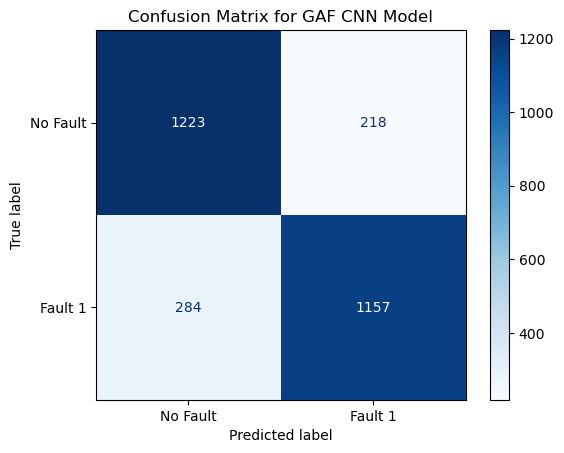

In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from pyts.image import GramianAngularField
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the dataset and define the no fault and fault 1 subsets
data = pd.read_csv("TEP_Fault_dataset_modified.csv")
data = data.drop(0)  # Dropping the header row if necessary
data.reset_index(drop=True, inplace=True)

# Divide the dataset into "no fault" and "fault 1" data
no_fault_data = data[:7201]
fault_1_data = data[7201:14402]

# Splitting each category by the specified proportions
def split_data(category_data, train_percent=0.6, val_percent=0.2, test_percent=0.2):
    train_end = int(train_percent * len(category_data))
    val_end = train_end + int(val_percent * len(category_data))
    
    train_data = category_data[:train_end]
    val_data = category_data[train_end:val_end]
    test_data = category_data[val_end:]
    
    return train_data, val_data, test_data

# Applying the split to both categories
no_fault_train, no_fault_val, no_fault_test = split_data(no_fault_data)
fault_1_train, fault_1_val, fault_1_test = split_data(fault_1_data)

# Concatenate each split part for final train, validation, and test sets
train_data = pd.concat([no_fault_train, fault_1_train], ignore_index=True)
val_data = pd.concat([no_fault_val, fault_1_val], ignore_index=True)
test_data = pd.concat([no_fault_test, fault_1_test], ignore_index=True)

# Separate features and labels
X_train = train_data.drop(columns=["Fault_1", "Fault_2", "Fault_3"])
y_train = train_data["Fault_1"]

X_val = val_data.drop(columns=["Fault_1", "Fault_2", "Fault_3"])
y_val = val_data["Fault_1"]

X_test = test_data.drop(columns=["Fault_1", "Fault_2", "Fault_3"])
y_test = test_data["Fault_1"]

# Save the test data to a new .dat file
X_test.to_csv("X_test.dat", header=False, index=False, sep=" ")

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Transform time series data into GAF images
gaf_transformer = GramianAngularField(image_size=32, method='summation')

def transform_to_gaf(data):
    gaf_images = np.array([gaf_transformer.fit_transform(series.reshape(1, -1))[0] for series in data])
    return gaf_images

# Convert scaled data to GAF images
X_train_gaf = transform_to_gaf(X_train_scaled)
X_val_gaf = transform_to_gaf(X_val_scaled)
X_test_gaf = transform_to_gaf(X_test_scaled)

# Add an extra dimension for the CNN input (channel dimension)
X_train_gaf = X_train_gaf[..., np.newaxis]
X_val_gaf = X_val_gaf[..., np.newaxis]
X_test_gaf = X_test_gaf[..., np.newaxis]

# Define the CNN model for GAF images
def train_and_save_gaf_model():
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Adding early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train_gaf, y_train,
        epochs=30,
        batch_size=64,
        validation_data=(X_val_gaf, y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate test accuracy
    test_loss, test_accuracy = model.evaluate(X_test_gaf, y_test, verbose=1)
    print(f"\nTest Accuracy: {test_accuracy:.4f}")

    # Save model and scaler
    save_model(model, "gaf_fault_detection_model.keras")
    np.save("scaler.npy", scaler.mean_)
    np.save("scaler_var.npy", scaler.var_)

    print("GAF model and scaler saved.")
    return history,model

# Run GAF model training
history,model = train_and_save_gaf_model()

# Generate predictions and plot the confusion matrix
y_pred = (model.predict(X_test_gaf) > 0.5).astype("int32")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fault", "Fault 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for GAF CNN Model")
plt.show()

Model and scaler loaded successfully.
GAF-based model loaded successfully.
GAF-based model loaded successfully.
<class 'str'>


GAF-based model loaded successfully. 
GAF representation shape: (1, 32, 32, 1) 
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step 
Prediction for current row: 0.03658435121178627 
GAF representation shape: (1, 32, 32, 1) 
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step 
Prediction for current row: 0.03728115186095238 
GAF representation shape: (1, 32, 32, 1) 
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step 
Prediction for current row: 0.038129113614559174 
GAF representation shape: (1, 32, 32, 1) 
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step 
Prediction for current row: 0.03645322471857071 
GAF representation shape: (1, 32, 32, 1) 
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step 
Prediction for current row: 0.03724972531199455 
GAF representation shape: (1, 32, 32, 1) 
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step 
Prediction for current row: 0.03774355724453926 
GAF representation shape: (1, 32, 32, 1) 
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 
Prediction for current row: 0.03724140301346779 
GAF representation shape: (1, 32, 32, 1) 
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step 
Prediction for current row: 0.03571275621652603 
GAF representation shape: (1, 32, 32, 1) 
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step 
Prediction for current row: 0.03756676986813545 
GAF representation shape: (1, 32, 32, 1) 
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step 
Prediction for current row: 0.035608768463134766 
Alarm! No Fault detected more than 10 times. 
GAF representation shape: (1, 32, 32, 1) 
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step 
Prediction for current row: 0.03638467937707901 
GAF representation shape: (1, 32, 32, 1) 
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 
Prediction for current row: 0.037246223539114 
GAF representation shape: (1, 32, 32, 1) 
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step 
Prediction for current row: 0.035543229430913925 
GAF representation shape: (1, 32, 32, 1) 
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 
Prediction for current row: 0.03697517514228821 
GAF representation shape: (1, 32, 32, 1) 
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step 
Prediction for current row: 0.038220688700675964 
GAF representation shape: (1, 32, 32, 1) 
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step 
Prediction for current row: 0.036643944680690765 
GAF representation shape: (1, 32, 32, 1) 
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step 
Prediction for current row: 0.03700147569179535 
GAF representation shape: (1, 32, 32, 1) 
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step 
Prediction for current row: 0.035786714404821396 
GAF representation shape: (1, 32, 32, 1) 
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step 
Pre

Row
    [0] Column(align='center')
        [0] Button(button_type='success', name='Start', width=62)
        [1] Button(button_type='danger', name='Stop', width=62)
        [2] Button(button_type='primary', name='Reset', width=62)
        [3] Button(button_type='primary', name='Restart', width=50)
        [4] Select(options=['PCA', 'Neural Network', ...], value='PCA')
        [5] Markdown(str)
    [1] PNG(bytes, embed=True, width=800)
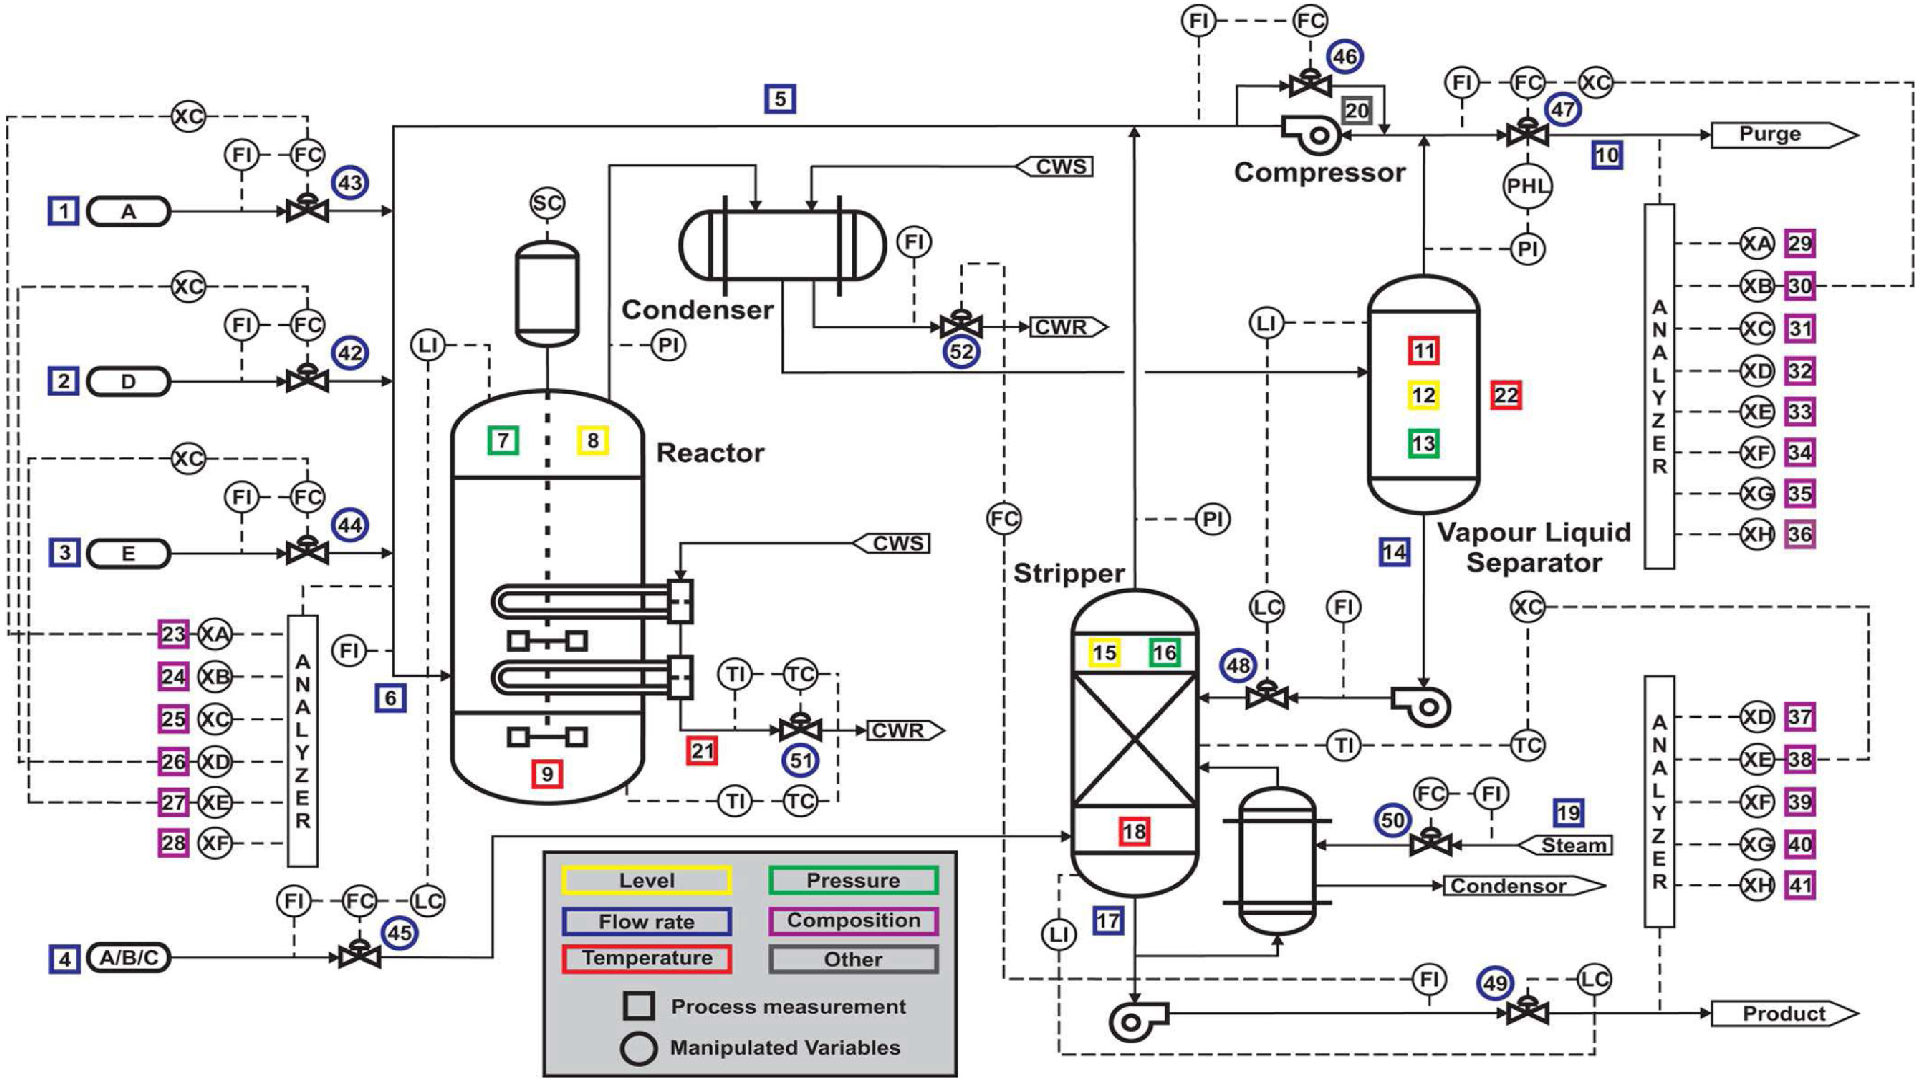

In [16]:
import os
import sys
import panel as pn
import pygame
import csv
import time
from PIL import ImageOps
from PIL import Image
from IPython.display import display, clear_output
from threading import Thread
import io
import numpy as np
import pandas as pd

import winsound

from sklearn.preprocessing import StandardScaler

# Import necessary modules for NN
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import LambdaCallback

from tensorflow.keras.models import load_model

import ipywidgets as widgets
from IPython.display import display, clear_output


# Initialize Pygame
pygame.init()

# Load the TEP file (CSV) and exclude the 46th column
tep_df = pd.read_csv("TEP_Fault_dataset_modified1.csv", header=None, dtype='object')

stop_count=0


class FaultDetectionSystem:
    def __init__(self):
        self.model = None
        self.scaler = None
        self.stream_data = None
        self.fault_counters = {"No Fault": 0, "Fault": 0}
        self.total_inferences = 0
        self.alarm_triggered = False
        self.stop_requested = False  # Initialize stop request as False
        
#         # Initialize output widget to display messages in Jupyter
#         self.output_widget = widgets.Output()
        
#         # Define buttons for user interaction when a fault is detected
#         self.continue_button = widgets.Button(description="Continue")
#         self.stop_button = widgets.Button(description="Stop")
#         self.continue_button.on_click(self.continue_simulation_action)
#         self.stop_button.on_click(self.stop_simulation)


    # Load the trained model and scaler
    def load_trained_model(self):
        self.model = load_model("fault_detection_model.keras")
        self.scaler = StandardScaler()
        self.scaler.mean_, self.scaler.var_ = np.load("scaler.npy"), np.load("scaler_var.npy")
        self.scaler.scale_ = np.sqrt(self.scaler.var_)
        print("Model and scaler loaded successfully.")

    # Load the continuous stream data from the .dat file
    def load_stream_data(self):
        try:
            self.stream_data = pd.read_csv("output_file5F.dat", header=None, sep=' ')
            self.load_trained_model()
            return True
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            return False

    # Process and detect faults in the continuous data stream
    def detect_faults_from_stream(self):
        if self.stream_data is None:
            print("Stream data not loaded.")
            return
        
        global stop_count
        
        global is_running
        is_running = True  # Start running the simulation
        
        # Iterate through each row in the stream data for real-time inference
        for _, row in self.stream_data.iterrows():
            if self.stop_requested:  # Check at each iteration
                print("Simulation stopped by user.")  # Added feedback
                is_running = False
                break
            
            # Preprocess the row (scale the data)
            row_scaled = self.scaler.transform([row])
            
            # Replace NaNs with the mean of each column if any NaNs are found after scaling
            if np.isnan(row_scaled).any():
                # Replace NaN values in row_scaled with the column mean
                row_scaled = np.nan_to_num(row_scaled, nan=np.nanmean(row_scaled))

            
            print(f"Scaled row data: {row_scaled}")
            
            # Make a prediction using the model
            prediction = self.model.predict(row_scaled)
            fault_detected = 1 if prediction[0][0] >= 0.8 else 0  # Index of the highest probability class
            
            print(f"Prediction for current row: {prediction[0][0]}")

            
            # Update fault counts and total inferences
            fault_name = "No Fault" if fault_detected == 0 else "Fault"
            self.fault_counters[fault_name] += 1
            self.total_inferences += 1

            # Check if alarm should be raised
            if self.fault_counters[fault_name] >= 10 and not self.alarm_triggered:
                winsound.Beep(1000, 1000)  # Frequency = 1000 Hz, Duration = 500 ms
                print(f"Alarm! {fault_name} detected more than 10 times.")
                self.alarm_triggered = True
                
            # # Check if fault has been detected more than 15 times
            # if self.fault_counters[fault_name] > 15:
            #     self.show_prompt(fault_name)
            #     break  # Pause the stream for user input

        # Print final summary
        self.print_summary()
        
        print(f"Prediction shape: {prediction.shape}, Prediction: {prediction}")

        
#     def show_prompt(self, fault_name):
#         # Display a prompt with "Continue" or "Stop" options in the notebook
#         with self.output_widget:
#             clear_output()
#             print(f"Warning: {fault_name} detected more than 15 times.")
#             display(self.continue_button, self.stop_button)
#         display(self.output_widget)

#     def continue_simulation_action(self, b):
#         # User chose to continue the simulation
#         self.alarm_triggered = True  # Prevent repeated prompts
#         self.continue_simulation = True
#         with self.output_widget:
#             clear_output()
#             print("Continuing the simulation...")

#     def stop_simulation(self, b=None):
#         # Stop the simulation and print summary
#         self.continue_simulation = False
#         self.print_summary()
#         with self.output_widget:
#             clear_output()
#             print("Simulation stopped.")


    # Print the summary of all inferences and faults detected
    def print_summary(self):
        print("\nFault Detection Summary:")
        print(f"Total Inferences: {self.total_inferences}")
        for fault, count in self.fault_counters.items():
            print(f"{fault}: {count} occurrences")


# Initialize the system and start/stop detection

fault_detection_system = FaultDetectionSystem()
fault_detection_system.load_trained_model()


class FaultDetectionSystem_GAF:
    def __init__(self):
        self.model = None
        self.scaler = None
        self.stream_data = None
        self.fault_counters = {"No Fault": 0, "Fault": 0}
        self.total_inferences = 0
        self.alarm_triggered = False
        self.stop_requested = False  # Initialize stop request as False

        # Initialize GAF transformer (adjust image size as needed)
        self.gaf_transformer = GramianAngularField(image_size=32, method='summation')  # Choose appropriate size

    # Load the trained model
    def load_trained_model(self):
        self.model = load_model("gaf_fault_detection_model.keras")
        print("GAF-based model loaded successfully.")

    # Load the continuous stream data from the .dat file
    def load_stream_data(self):
        try:
            self.stream_data = pd.read_csv("X_test.dat", header=None, sep=' ')
            self.load_trained_model()
            return True
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            return False

    # Transform each row into a GAF image and detect faults
    def detect_faults_from_stream(self):
        if self.stream_data is None:
            print("Stream data not loaded.")
            return

        global is_running
        is_running = True  # Start running the simulation

        for _, row in self.stream_data.iterrows():
            if self.stop_requested:  # Check if stop has been requested
                print("Simulation stopped by user.")
                is_running = False
                break
            
            # Scale the row data
            row = np.array(row).reshape(1, -1)  # Ensure row is 2D
            row_scaled = self.scaler.transform(row) if self.scaler else row
            
             # Replace NaNs with the mean of each column if any NaNs are found after scaling
            if np.isnan(row_scaled).any():
                # Replace NaN values in row_scaled with the column mean
                row_scaled = np.nan_to_num(row_scaled, nan=np.nanmean(row_scaled))


            # Convert row data to GAF image
            row_gaf = self.gaf_transformer.transform(row_scaled)  # Output shape is (1, image_size, image_size)
            row_gaf = np.expand_dims(row_gaf, axis=-1)  # Add channel dimension

            print(f"GAF representation shape: {row_gaf.shape}")

            # Predict using the model
            prediction = self.model.predict(row_gaf)
            fault_detected = 1 if prediction[0][0] >= 0.8 else 0
            
            print(f"Prediction for current row: {prediction[0][0]}")


            # Update fault counts and total inferences
            fault_name = "No Fault" if fault_detected == 0 else "Fault"
            self.fault_counters[fault_name] += 1
            self.total_inferences += 1

            # Raise alarm if necessary
            if self.fault_counters[fault_name] >= 10 and not self.alarm_triggered:
                winsound.Beep(1000, 1000)  # Frequency = 1000 Hz, Duration = 1000 ms
                print(f"Alarm! {fault_name} detected more than 10 times.")
                self.alarm_triggered = True

        # Print final summary
        self.print_summary()
        
    # Print summary of all inferences and faults detected
    def print_summary(self):
        print("\nFault Detection Summary:")
        print(f"Total Inferences: {self.total_inferences}")
        for fault, count in self.fault_counters.items():
            print(f"{fault}: {count} occurrences")

# Initialize the system and load model/stream data
fault_detection_system = FaultDetectionSystem_GAF()
fault_detection_system.load_trained_model()
fault_detection_system.load_stream_data()


# Define box coordinates
BOX1_COORDINATES = ((32, 160), (162, 190))
BOX2_COORDINATES = ((32, 330), (162, 360))
BOX3_COORDINATES = ((32, 502), (162, 532))
BOX4_COORDINATES = ((18, 906), (148, 936))
BOX5_COORDINATES = ((730, 46), (860, 76))
BOX6_COORDINATES = ((319, 716), (449, 746))
BOX7_COORDINATES = ((456, 481), (586, 511))
BOX8_COORDINATES = ((650, 404), (780, 434))
BOX9_COORDINATES = ((498, 806), (628, 834))
BOX10_COORDINATES = ((1562, 172), (1692, 202))
BOX11_COORDINATES = ((1486, 335), (1616, 365))
BOX12_COORDINATES = ((1486, 380), (1616, 410))
BOX13_COORDINATES = ((1486, 430), (1616, 460))
BOX14_COORDINATES = ((1281, 517), (1411, 547))
BOX15_COORDINATES = ((965, 550), (1095, 580))
BOX16_COORDINATES = ((1137, 550), (1265, 580))
BOX17_COORDINATES = ((1138, 932), (1268, 962))
BOX18_COORDINATES = ((1088, 850), (1218, 878))
BOX19_COORDINATES = ((1520, 764), (1650, 794))
BOX20_COORDINATES = ((1338, 150), (1468, 180))
BOX21_COORDINATES = ((642, 768), (772, 798))
BOX22_COORDINATES = ((1520, 476), (1650, 506))
BOX23_COORDINATES = ((43, 610), (173, 640))
BOX24_COORDINATES = ((43, 662), (173, 692))
BOX25_COORDINATES = ((43, 704), (173, 734))
BOX26_COORDINATES = ((43, 754), (173, 784))
BOX27_COORDINATES = ((43, 796), (173, 826))
BOX28_COORDINATES = ((43, 834), (173, 864))
BOX29_COORDINATES = ((1783, 228), (1913, 258))
BOX30_COORDINATES = ((1783, 276), (1913, 306))
BOX31_COORDINATES = ((1783, 313), (1913, 343))
BOX32_COORDINATES = ((1783, 356), (1913, 386))
BOX33_COORDINATES = ((1783, 396), (1913, 426))
BOX34_COORDINATES = ((1783, 437), (1913, 467))
BOX35_COORDINATES = ((1783, 478), (1913, 508))
BOX36_COORDINATES = ((1783, 519), (1913, 549))
BOX37_COORDINATES = ((1783, 701), (1913, 731))
BOX38_COORDINATES = ((1783, 749), (1913, 779))
BOX39_COORDINATES = ((1783, 786), (1913, 816))
BOX40_COORDINATES = ((1783, 829), (1913, 859))
BOX41_COORDINATES = ((1783, 870), (1913, 900))
BOX42_COORDINATES = ((323, 300), (453, 330))
BOX43_COORDINATES = ((323, 130), (453, 160))
BOX44_COORDINATES = ((323, 474), (453, 504))
BOX45_COORDINATES = ((388, 966), (518, 996))
BOX46_COORDINATES = ((1330, 6), (1460, 36))
BOX47_COORDINATES = ((1584, 100), (1714, 130))
BOX48_COORDINATES = ((1269, 645), (1399, 675))
BOX49_COORDINATES = ((1438, 930), (1568, 960))
BOX50_COORDINATES = ((1310, 766), (1440, 796))
BOX51_COORDINATES = ((840, 744), (970, 774))
BOX52_COORDINATES = ((908, 376), (1038, 406))


# Define constants
DAT_PATH = "X_test.dat"
BOX_COORDINATES = [
    BOX1_COORDINATES, BOX2_COORDINATES, BOX3_COORDINATES, BOX4_COORDINATES, BOX5_COORDINATES, BOX6_COORDINATES, BOX7_COORDINATES, BOX8_COORDINATES, BOX9_COORDINATES, BOX10_COORDINATES, BOX11_COORDINATES,
    BOX12_COORDINATES, BOX13_COORDINATES, BOX14_COORDINATES, BOX15_COORDINATES, BOX16_COORDINATES, BOX17_COORDINATES, BOX18_COORDINATES, BOX19_COORDINATES, BOX20_COORDINATES, BOX21_COORDINATES, BOX22_COORDINATES, 
    BOX23_COORDINATES, BOX24_COORDINATES, BOX25_COORDINATES, BOX26_COORDINATES, BOX27_COORDINATES, BOX28_COORDINATES, BOX29_COORDINATES, BOX30_COORDINATES, BOX31_COORDINATES, BOX32_COORDINATES, BOX33_COORDINATES, 
    BOX34_COORDINATES, BOX35_COORDINATES, BOX36_COORDINATES, BOX37_COORDINATES, BOX38_COORDINATES, BOX39_COORDINATES, BOX40_COORDINATES, BOX41_COORDINATES, BOX42_COORDINATES, BOX43_COORDINATES, BOX44_COORDINATES, 
    BOX45_COORDINATES, BOX46_COORDINATES, BOX47_COORDINATES, BOX48_COORDINATES, BOX49_COORDINATES, BOX50_COORDINATES, BOX51_COORDINATES, BOX52_COORDINATES
]

# Function to read data from CSV file and store it as a matrix
def read_csv_to_matrix(csv_path):
    matrix = []
    with open(csv_path, "r") as file:
        reader = csv.reader(file)
        for row in reader:
            #cleaned_row = [float(x.strip()) for x in " ".join(row).split()]
            matrix.append(row)
    return matrix

def read_csv_to_matrix2(csv_path):
    matrix = []
    with open(csv_path, "r") as file:
        reader = csv.reader(file)
        for row in reader:
            cleaned_row = [float(x.strip()) for x in " ".join(row).split()]
            matrix.append(cleaned_row)
    return matrix

# Load data from the file
matrix = read_csv_to_matrix(DAT_PATH)
print(type(matrix[0][0]))


# Define a flag to control the simulation state
is_running = False

# Define font
font = pygame.font.Font(None, 24)

row_index = 0

# Define groups of boxes with the same color
BOX_GROUPS = {
    "Group1": [BOX1_COORDINATES, BOX2_COORDINATES, BOX3_COORDINATES, BOX4_COORDINATES, BOX5_COORDINATES, BOX6_COORDINATES, BOX10_COORDINATES, BOX14_COORDINATES, BOX17_COORDINATES, 
               BOX19_COORDINATES, BOX42_COORDINATES, BOX43_COORDINATES, BOX44_COORDINATES, BOX45_COORDINATES, BOX46_COORDINATES, BOX47_COORDINATES, BOX48_COORDINATES, BOX49_COORDINATES, 
               BOX50_COORDINATES, BOX51_COORDINATES, BOX52_COORDINATES],
    "Group2": [BOX23_COORDINATES, BOX24_COORDINATES, BOX25_COORDINATES, BOX26_COORDINATES, BOX27_COORDINATES, BOX28_COORDINATES, BOX29_COORDINATES, BOX30_COORDINATES, BOX31_COORDINATES, 
               BOX32_COORDINATES, BOX33_COORDINATES, BOX34_COORDINATES, BOX35_COORDINATES, BOX36_COORDINATES, BOX37_COORDINATES, BOX38_COORDINATES, BOX39_COORDINATES, BOX40_COORDINATES, 
               BOX41_COORDINATES],
    "Group3": [BOX9_COORDINATES, BOX11_COORDINATES, BOX18_COORDINATES, BOX21_COORDINATES, BOX22_COORDINATES],
    "Group4": [BOX7_COORDINATES, BOX13_COORDINATES, BOX16_COORDINATES],
    "Group5": [BOX8_COORDINATES, BOX12_COORDINATES, BOX15_COORDINATES],
    "Group6": [BOX20_COORDINATES],
    
    
}

# Define colors for each group
GROUP_COLORS = {
    "Group1": (42, 46, 110),       # BLUE
    "Group2": (141, 48, 119),      # PINK
    "Group3": (191, 32, 50),       # RED
    "Group4": (39, 147, 89),       # GREEN
    "Group5": (237, 231, 35),      # GREEN
    "Group6": (99, 99, 99),        #GREY
}

# Function to generate Pygame image
def generate_pygame_image():
    global row_index
    image_path = "Dc2image.jpg"
    image = pygame.image.load(image_path)
    image = pygame.transform.scale(image, (1920, 1080))
    
    for group_name, boxes in BOX_GROUPS.items():
        group_color = GROUP_COLORS.get(group_name, (255, 255, 255))  # Default color is white
        for box in boxes:
            pygame.draw.rect(image, group_color, (*box[0], box[1][0] - box[0][0], box[1][1] - box[0][1]), 4)
    
    for index, box in enumerate(BOX_COORDINATES):
        if index < len(matrix):  # Check if there is enough data for this box
            row_data = matrix[row_index][0].split()[index]
            box_text = font.render(row_data, True, (255, 0, 0))
            # Calculate the center position of the box
            center_x = (box[0][0] + box[1][0]) // 2
            center_y = (box[0][1] + box[1][1]) // 2
            text_width, text_height = font.size(row_data)
            text_x = center_x - text_width // 2
            text_y = center_y - text_height // 2
            image.blit(box_text, (text_x, text_y))

    pygame_surface = pygame.surfarray.pixels3d(image)
    pil_image = Image.fromarray(pygame_surface[:, :, [0, 1, 2]])  # Direct conversion to PIL, skipping unnecessary transposes
    pil_image = pil_image.rotate(90, expand=True)
    pil_image = ImageOps.flip(pil_image)
    return pil_image


# Global flag to control the execution of the function
is_running = False

def generate_pygame_image2():
    global row_index
    image_path = "Dc2image.jpg"
    image = pygame.image.load(image_path)
    image = pygame.transform.scale(image, (1920, 1080))


    pygame_surface = pygame.surfarray.pixels3d(image)
    pil_image = Image.fromarray(pygame_surface[:, :, [0, 1, 2]])  # Direct conversion to PIL, skipping unnecessary transposes
    pil_image = pil_image.rotate(90, expand=True)
    pil_image = ImageOps.flip(pil_image)
    return pil_image

# Define Panel app
pn.extension()
start_button = pn.widgets.Button(name='Start', button_type='success', width=62)
stop_button = pn.widgets.Button(name='Stop', button_type='danger', width=62)
restart_button = pn.widgets.Button(name='Restart', button_type='primary', width=50)
reset_button = pn.widgets.Button(name='Reset', button_type='primary', width=62)
# Dropdown for fault detection technologies
fault_detection_select = pn.widgets.Select(name='Select Fault Detection Technology', 
                                           options=['PCA', 'Neural Network', 'GAF', 'RP'])




# Create a single image pane to display images
image_pane = pn.pane.PNG(width=800, embed=True)  #image_pane = pn.pane.PNG(width=1920, height=1080, embed=True),,,,,(width=1386, height=780, embed=True)

# Panel to display results
result_panel = pn.pane.Markdown("Result will be displayed here.")

layout = pn.Row(
    pn.Column(start_button, stop_button, reset_button, restart_button,fault_detection_select,result_panel,align="center"),
    image_pane
)

pil_image = generate_pygame_image2()
img_byte_arr = io.BytesIO()
pil_image.save(img_byte_arr, format='PNG')
image_pane.object = img_byte_arr.getvalue()    

    
def controlled_function():
    global is_running, row_index
    while is_running and row_index < 960:
        pil_image = generate_pygame_image()
        img_byte_arr = io.BytesIO()
        pil_image.save(img_byte_arr, format='PNG')
        image_pane.object = img_byte_arr.getvalue()
        time.sleep(1)
        row_index += 1

def start_function(event):
    result_panel.object="Result will be displayed here."
    global is_running, row_index, stop_count
    stop_count=0
    if not is_running:
        is_running = True
        thread = Thread(target=controlled_function)
        thread.start()

def stop_function(fault_detection_system,event=None):
    global is_running, row_index, stop_count
    is_running = False
    #stop_count=1
    fault_detection_system.stop_requested= True
    
def restart_function(event):
    global is_running, row_index, stop_count
    if not is_running:
    #     is_running=False
        row_index=0
        stop_count=0
        start_function(event)
    
def reset_function(event):
    global is_running, row_index
    if is_running:
        is_running = False
    row_index = 0
    pil_image = generate_pygame_image()
    img_byte_arr = io.BytesIO()
    pil_image.save(img_byte_arr, format='PNG')
    image_pane.object = img_byte_arr.getvalue() 
    
# Sample function for fault detection (to be expanded with actual logic)
def detect_fault():
    #stop_function(event)
    
    unlabelled_data= read_csv_to_matrix2(DAT_PATH)
    unlabelled_data = np.array(unlabelled_data)
    #dummy_feature = np.full((unlabelled_data.shape[0], 1), 100)
    #unlabelled_data_with_dummy = np.hstack((unlabelled_data, dummy_feature))
    
    row_data = unlabelled_data[row_index]
    row_data_reshaped = np.array(row_data).reshape(1, -1)
    
    if fault_detection_select.value == 'PCA':
        detect_fault_using_pca(row_data_reshaped)
    elif fault_detection_select.value == 'Neural Network':
        # Instantiate the system and run the detection
        fault_system = FaultDetectionSystem()
        if fault_system.load_stream_data():
            fault_system.detect_faults_from_stream()

    elif fault_detection_select.value == 'GAF':
        # Instantiate the system in GAF mode and run the detection
        fault_system = FaultDetectionSystem_GAF()
        if fault_system.load_stream_data():
            fault_system.detect_faults_from_stream()
            
    elif fault_detection_select.value == 'RP':
        return "Detected fault using RP"
    else:
        return "Select a valid technology"


def detect_fault_in_unlabelled_data(row_data, pca_fit, control_upper_limit, control_lower_limit, scaling_factor):
    # Standardize the input
    scaled_row_data = scaling_factor.transform(row_data)
    
    # Apply PCA transformation and inverse transformation
    pca_transformed = pca_fit.transform(scaled_row_data)
    reconstructed_data = pca_fit.inverse_transform(pca_transformed)
    
    # Compute the residual error for each feature
    residual_errors = ((scaled_row_data - reconstructed_data) ** 2).flatten()
    
    # Identify faulty features where residual error exceeds control limits
    faulty_features = []
    for i, error in enumerate(residual_errors):
        if error > control_upper_limit or error < control_lower_limit:  # You can also use control_lower_limit depending on the nature of your data
            faulty_features.append(i)
    
    return faulty_features  # Ensure there are no hidden non-printable characters here



# Button functionality for fault detection
def detect_fault_using_pca(row_data_reshaped):

    # Train PCA model and control limits
    pca_fit, control_upper_limit, control_lower_limit, scaling_factor = train_pca_model()
    
    # Detect faults in unlabelled data
    faulty_samples = detect_fault_in_unlabelled_data(row_data_reshaped, pca_fit, control_upper_limit, control_lower_limit, scaling_factor)
    
    # Display result
    if len(faulty_samples) > 0:
        winsound.Beep(1000, 1000)  # Frequency = 1000 Hz, Duration = 500 ms
        faulty_indices_str = ', '.join(map(str, faulty_samples))
        num_faulty= len(faulty_samples)
        result_panel.object = f"Fault Detected in features at indices: {faulty_indices_str}\nTotal faulty features: {num_faulty}"
        #stop_function(event)
    else:
        result_panel.object = "No Fault Detected"
        
# # Function to detect faults using the trained neural network model
# def detect_fault_using_nn(row_data, model, scaling_factor):
#     global stop_count
    
#     # Standardize the input data using the same scaling factor
#     scaled_row_data = scaling_factor.transform(row_data)
    
#     # Make a prediction using the neural network model
#     prediction = model.predict(scaled_row_data)
    
#     # If prediction > 0.5, we consider it a fault
#     if prediction[0][0] > 0.5:
#         result_panel.object = "Fault_1 Detected!"
#         # if stop_count>0:
#         #     stop_function()
#         # else:
#         #     detect_fault()
#         #detect_fault()   
#         #stop_function(event)  # Stop simulation if a fault is detected
#         return 
#     elif prediction[0][1]>0.5:
#         result_panel.object = "Fault_2 Detected!"
#         # if stop_count>0:
#         #     stop_function()
#         # else:
#         #     detect_fault()
#         #detect_fault()   
#         #stop_function(event)  # Stop simulation if a fault is detected
#         return
#     elif prediction[0][2]>0.5:
#         result_panel.object = "Fault_3 Detected!"
#         # if stop_count>0:
#         #     stop_function()
#         # else:
#         #     detect_fault()
#         #detect_fault()   
#         #stop_function(event)  # Stop simulation if a fault is detected
#         return
#     else:
#         result_panel.object = " No Fault Detected!" # No fault detected
#         # if stop_count>0:
#         #     stop_function()
#         # else:
#         #     detect_fault()
#         #detect_fault()   
#         return

# # Button functionality for fault detection using neural network
# def on_nn_fault_detection_button_click(row_data_reshaped):

#     # Instantiate the system and run the detection
#     fault_system = FaultDetectionSystem()
#     if fault_system.load_stream_data():
#         fault_system.detect_faults_from_stream()

    # Display result
    # if fault_detected:
    #     #print(f'Test accuracy: {accuracy}')
    #     result_panel.object = "Fault Detected!"
    #     stop_function(event)  # Stop simulation if a fault is detected
    # else:
    #     #print(f'Test accuracy: {accuracy}')
    #     result_panel.object = "No Fault Detected"
        
# Combined function to call both start_function and detect_fault
def start_and_detect(event):
    start_function(event)      # Calls start function
    detect_fault()        # Calls detect fault function
    
# def stop_and_summary(event):
#     stop_function(event)
#     generate_fault_summary()

    
# # Initialize variables outside of the detection function
# processed_data = []  # This list will accumulate fault types for each row processed
# fault_summary = []

# # Function to detect and accumulate fault results for each row
# def accumulate_fault_data(row_data):
#     # Detect the fault type for the current row
#     fault_type = detect_fault(row_data)  # Function that returns 'No Fault', 'Fault_1', etc.
#     processed_data.append(fault_type)  # Append each result to processed_data list

# # Function to generate fault summary on stop
# def generate_fault_summary():
#     # Initialize variables to store the fault summary
#     summary = []
#     previous_fault = None
#     start_index = 1

#     # Use processed_data to generate summary
#     for index, fault_type in enumerate(processed_data, start=1):
#         # Check if the current fault type is the same as the previous one
#         if fault_type == previous_fault:
#             continue
#         else:
#             # Record the range and fault type if there's a change
#             if previous_fault is not None:
#                 summary.append(f"{start_index}-{index - 1}: {previous_fault}")
#             start_index = index
#             previous_fault = fault_type

#     # Record the final range
#     if previous_fault is not None:
#         summary.append(f"{start_index}-{len(processed_data)}: {previous_fault}")

#     # Print or display the summary
#     print("\n".join(summary))

# Call accumulate_fault_data(row) on each row during simulation
# Then, call generate_fault_summary() only when the stop button is clicked


# Print or display the summary
#print("\n".join(fault_summary))



# Link buttons to their respective functions
start_button.on_click(start_and_detect)
#stop_button.on_click(stop_function)
# Assuming fault_detection_system is an instance of FaultDetectionSystem
stop_button.on_click(lambda _: stop_function(fault_detection_system))

restart_button.on_click(restart_function)
reset_button.on_click(reset_function)

# Display the layout
layout.servable()


Model and scaler loaded successfully.
<class 'str'>


Model and scaler loaded successfully. 
Scaled row data: [[ 0.45372555 -1.88997305 -0.67302908 -0.31692767 0.1995395 0.24637338 
 0.67653497 0.27374359 0.37000684 0.98332776 1.07912558 -1.37275009 
 0.5839204 0.09286654 1.15689892 0.61160112 1.46517341 0.97200445 
 0.32826222 0.36975845 1.64829561 0.58655197 0.49786731 0.97626589 
 -0.84692669 -1.03316386 0.33554786 1.49181591 0.70518027 0.79610709 
 -1.19948022 0.48741333 0.72084485 1.2978291 1.34445679 0.42618927 
 -2.14573207 -0.22845713 -0.06958978 -1.79554742 0.37642697 -2.90525909 
 -1.68353944 0.45684074 -0.47117264 0.92000645 -1.47757999 -0.51889883 
 0.10206011 -0.82764129 1.628172 0.10206011]] 
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step 
Prediction for current row: 1.0 
Scaled row data: [[ 0.45433445 -1.91385758 -0.86321069 -0.25803852 0.67994238 -0.55433336 
 0.55970605 1.38076049 -1.38843472 1.01696952 0.97657617 -1.80388637 
 0.57609253 -1.35320966 1.54083555 0.58596918 -0.0631079 0.94863777 
 0.01811364 0.33999786 1.68801618 0.51493058 0.30987626 0.92291285 
 -0.81857176 0.62701901 0.26459226 0.92605048 0.68057016 1.19647069 
 -1.02044957 -0.71563203 0.5058814 0.99587039 0.21105449 -0.1818952 
 -2.14573207 -0.22845713 -0.06958978 -1.79554742 0.37642697 -2.76171489 
 -1.69837543 0.45899563 -0.46682267 0.93326316 -1.37079112 -0.2296906 
 -0.06909636 -1.06411928 -0.37921659 -0.06909636]] 
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step 
Prediction for current row: 1.0 
Scaled row data: [[ 0.46893207 -1.88662396 -1.97936425 -0.33014841 0.44938046 0.14186591 
 0.48262287 0.87523895 -2.11282929 1.01367468 0.8777955 -1.09170601 
 0.43030809 -0.68320554 1.55310823 0.54965423 0.43756671 0.93528503 
 2.86781596 0.28046069 1.2997499 0.53916191 0.30987626 0.92291285 
 -0.81857176 0.62701901 0.26459226 0.92605048 0.68057016 1.19647069 
 -1.02044957 -0.71563203 0.5058814 0.99587039 0.21105449 -0.1818952 
 -2.14573207 -0.22845713 -0.06958978 -1.79554742 0.37642697 -2.66892144 
 -1.75080055 0.46070118 -0.47006318 0.94291243 -1.28854861 -0.14520981 
 -0.04578434 -1.43147766 -1.09740313 -0.04578434]] 
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 
Prediction for current row: 1.0 
Scaled row data: [[ 0.45678871 -0.18989577 -1.13134602 -0.56871244 0.3755031 -0.54685061 
 0.56327693 0.02706101 0.77508723 0.98037074 0.87669189 -1.68890758 
 0.39528397 -1.51474314 1.55799111 0.56468129 0.55006598 0.90024898 
 1.03280679 0.27658152 1.62908283 0.52766068 0.30987626 0.92291285 
 -0.81857176 0.62701901 0.26459226 0.92605048 0.68057016 1.19647069 
 -1.02044957 -0.71563203 0.5058814 0.99587039 0.21105449 -0.1818952 
 -2.14573207 -0.22845713 -0.06958978 -1.79554742 0.37642697 -2.62610726 
 -1.89058921 0.46215668 -0.49307333 0.95041426 -1.28908767 -0.25369211 
 0.016274 -1.60094305 1.66504468 0.016274 ]] 
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step 
Prediction for current row: 1.0 
Scaled row data: [[ 0.46160875 -1.98178822 -2.21269224 -0.1002943 1.23251839 0.24053189 
 0.44912355 -0.29054321 0.52500192 0.96466082 0.8302065 -1.15278269 
 0.36186436 -1.38936275 1.52775065 0.46620481 0.73033505 0.94207857 
 0.16414987 0.30633387 1.65463774 0.44769158 0.30987626 0.92291285 
 -0.81857176 0.62701901 0.26459226 0.92605048 0.68057016 1.19647069 
 -1.02044957 -0.71563203 0.5058814 0.99587039 0.21105449 -0.1818952 
 -2.14573207 -0.22845713 -0.06958978 -1.79554742 0.37642697 -2.59475808 
 -1.95483833 0.46350282 -0.50421338 0.95793226 -1.28724421 -0.24622193 
 -0.02838666 -1.03488243 0.56330547 -0.02838666]] 
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 
Prediction for current row: 1.0 
Scaled row data: [[ 0.47563651 -1.42071317 -2.99937825 -0.55643514 0.

Row
    [0] Column(align='center')
        [0] Button(button_type='success', name='Start', width=62)
        [1] Button(button_type='danger', name='Stop', width=62)
        [2] Button(button_type='primary', name='Reset', width=62)
        [3] Button(button_type='primary', name='Restart', width=50)
        [4] Select(options=['PCA', 'Neural Network', ...], value='PCA')
        [5] Markdown(str)
    [1] PNG(bytes, embed=True, width=800)
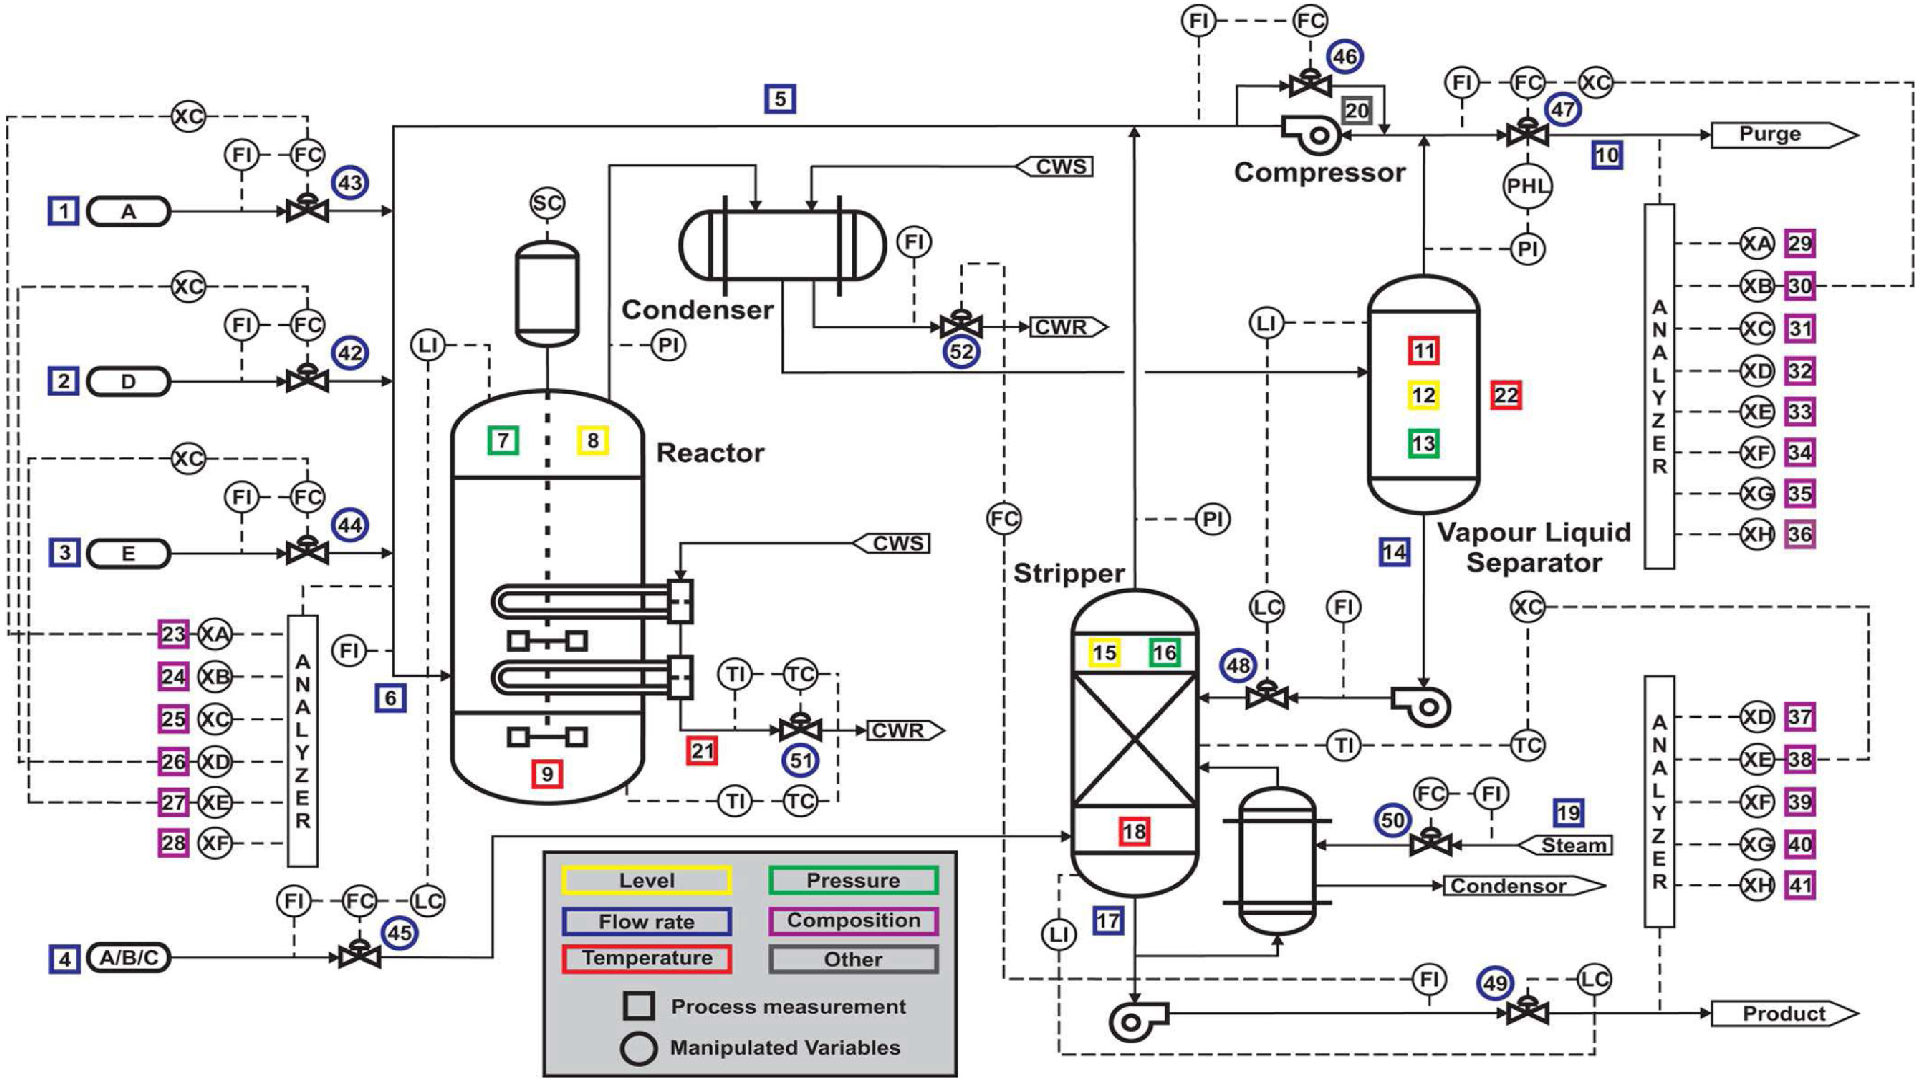

In [2]:
import os
import sys
import panel as pn
import pygame
import csv
import time
from PIL import ImageOps
from PIL import Image
from IPython.display import display, clear_output
from threading import Thread
import io
import numpy as np
import pandas as pd

import winsound

from sklearn.preprocessing import StandardScaler

# Import necessary modules for NN
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import LambdaCallback

from tensorflow.keras.models import load_model

import ipywidgets as widgets
from IPython.display import display, clear_output


# Initialize Pygame
pygame.init()

# Load the TEP file (CSV) and exclude the 46th column
tep_df = pd.read_csv("TEP_Fault_dataset_modified1.csv", header=None, dtype='object')

stop_count=0


class FaultDetectionSystem:
    def __init__(self):
        self.model = None
        self.scaler = None
        self.stream_data = None
        self.fault_counters = {"No Fault": 0, "Fault": 0}
        self.total_inferences = 0
        self.alarm_triggered = False
        self.stop_requested = False  # Initialize stop request as False
        
#         # Initialize output widget to display messages in Jupyter
#         self.output_widget = widgets.Output()
        
#         # Define buttons for user interaction when a fault is detected
#         self.continue_button = widgets.Button(description="Continue")
#         self.stop_button = widgets.Button(description="Stop")
#         self.continue_button.on_click(self.continue_simulation_action)
#         self.stop_button.on_click(self.stop_simulation)


    # Load the trained model and scaler
    def load_trained_model(self):
        self.model = load_model("fault_detection_model.keras")
        self.scaler = StandardScaler()
        self.scaler.mean_, self.scaler.var_ = np.load("scaler.npy"), np.load("scaler_var.npy")
        self.scaler.scale_ = np.sqrt(self.scaler.var_)
        print("Model and scaler loaded successfully.")

    # Load the continuous stream data from the .dat file
    def load_stream_data(self):
        try:
            self.stream_data = pd.read_csv("output_file5F.dat", header=None, sep=' ')
            self.load_trained_model()
            return True
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            return False

    # Process and detect faults in the continuous data stream
    def detect_faults_from_stream(self):
        if self.stream_data is None:
            print("Stream data not loaded.")
            return
        
        global stop_count
        
        global is_running
        is_running = True  # Start running the simulation
        
        # Iterate through each row in the stream data for real-time inference
        for _, row in self.stream_data.iterrows():
            if self.stop_requested:  # Check at each iteration
                print("Simulation stopped by user.")  # Added feedback
                is_running = False
                break
            
            # Preprocess the row (scale the data)
            row_scaled = self.scaler.transform([row])
            
            # Replace NaNs with the mean of each column if any NaNs are found after scaling
            if np.isnan(row_scaled).any():
                # Replace NaN values in row_scaled with the column mean
                row_scaled = np.nan_to_num(row_scaled, nan=np.nanmean(row_scaled))

            
            print(f"Scaled row data: {row_scaled}")
            
            # Make a prediction using the model
            prediction = self.model.predict(row_scaled)
            fault_detected = 1 if prediction[0][0] >= 0.8 else 0  # Index of the highest probability class
            
            print(f"Prediction for current row: {prediction[0][0]}")

            
            # Update fault counts and total inferences
            fault_name = "No Fault" if fault_detected == 0 else "Fault"
            self.fault_counters[fault_name] += 1
            self.total_inferences += 1

            # Check if alarm should be raised
            if self.fault_counters[fault_name] >= 10 and not self.alarm_triggered:
                winsound.Beep(1000, 1000)  # Frequency = 1000 Hz, Duration = 500 ms
                print(f"Alarm! {fault_name} detected more than 10 times.")
                self.alarm_triggered = True
                
            # # Check if fault has been detected more than 15 times
            # if self.fault_counters[fault_name] > 15:
            #     self.show_prompt(fault_name)
            #     break  # Pause the stream for user input

        # Print final summary
        self.print_summary()
        
        print(f"Prediction shape: {prediction.shape}, Prediction: {prediction}")

        
#     def show_prompt(self, fault_name):
#         # Display a prompt with "Continue" or "Stop" options in the notebook
#         with self.output_widget:
#             clear_output()
#             print(f"Warning: {fault_name} detected more than 15 times.")
#             display(self.continue_button, self.stop_button)
#         display(self.output_widget)

#     def continue_simulation_action(self, b):
#         # User chose to continue the simulation
#         self.alarm_triggered = True  # Prevent repeated prompts
#         self.continue_simulation = True
#         with self.output_widget:
#             clear_output()
#             print("Continuing the simulation...")

#     def stop_simulation(self, b=None):
#         # Stop the simulation and print summary
#         self.continue_simulation = False
#         self.print_summary()
#         with self.output_widget:
#             clear_output()
#             print("Simulation stopped.")


    # Print the summary of all inferences and faults detected
    def print_summary(self):
        print("\nFault Detection Summary:")
        print(f"Total Inferences: {self.total_inferences}")
        for fault, count in self.fault_counters.items():
            print(f"{fault}: {count} occurrences")


# Initialize the system and start/stop detection

fault_detection_system = FaultDetectionSystem()
fault_detection_system.load_trained_model()




# Define box coordinates
BOX1_COORDINATES = ((32, 160), (162, 190))
BOX2_COORDINATES = ((32, 330), (162, 360))
BOX3_COORDINATES = ((32, 502), (162, 532))
BOX4_COORDINATES = ((18, 906), (148, 936))
BOX5_COORDINATES = ((730, 46), (860, 76))
BOX6_COORDINATES = ((319, 716), (449, 746))
BOX7_COORDINATES = ((456, 481), (586, 511))
BOX8_COORDINATES = ((650, 404), (780, 434))
BOX9_COORDINATES = ((498, 806), (628, 834))
BOX10_COORDINATES = ((1562, 172), (1692, 202))
BOX11_COORDINATES = ((1486, 335), (1616, 365))
BOX12_COORDINATES = ((1486, 380), (1616, 410))
BOX13_COORDINATES = ((1486, 430), (1616, 460))
BOX14_COORDINATES = ((1281, 517), (1411, 547))
BOX15_COORDINATES = ((965, 550), (1095, 580))
BOX16_COORDINATES = ((1137, 550), (1265, 580))
BOX17_COORDINATES = ((1138, 932), (1268, 962))
BOX18_COORDINATES = ((1088, 850), (1218, 878))
BOX19_COORDINATES = ((1520, 764), (1650, 794))
BOX20_COORDINATES = ((1338, 150), (1468, 180))
BOX21_COORDINATES = ((642, 768), (772, 798))
BOX22_COORDINATES = ((1520, 476), (1650, 506))
BOX23_COORDINATES = ((43, 610), (173, 640))
BOX24_COORDINATES = ((43, 662), (173, 692))
BOX25_COORDINATES = ((43, 704), (173, 734))
BOX26_COORDINATES = ((43, 754), (173, 784))
BOX27_COORDINATES = ((43, 796), (173, 826))
BOX28_COORDINATES = ((43, 834), (173, 864))
BOX29_COORDINATES = ((1783, 228), (1913, 258))
BOX30_COORDINATES = ((1783, 276), (1913, 306))
BOX31_COORDINATES = ((1783, 313), (1913, 343))
BOX32_COORDINATES = ((1783, 356), (1913, 386))
BOX33_COORDINATES = ((1783, 396), (1913, 426))
BOX34_COORDINATES = ((1783, 437), (1913, 467))
BOX35_COORDINATES = ((1783, 478), (1913, 508))
BOX36_COORDINATES = ((1783, 519), (1913, 549))
BOX37_COORDINATES = ((1783, 701), (1913, 731))
BOX38_COORDINATES = ((1783, 749), (1913, 779))
BOX39_COORDINATES = ((1783, 786), (1913, 816))
BOX40_COORDINATES = ((1783, 829), (1913, 859))
BOX41_COORDINATES = ((1783, 870), (1913, 900))
BOX42_COORDINATES = ((323, 300), (453, 330))
BOX43_COORDINATES = ((323, 130), (453, 160))
BOX44_COORDINATES = ((323, 474), (453, 504))
BOX45_COORDINATES = ((388, 966), (518, 996))
BOX46_COORDINATES = ((1330, 6), (1460, 36))
BOX47_COORDINATES = ((1584, 100), (1714, 130))
BOX48_COORDINATES = ((1269, 645), (1399, 675))
BOX49_COORDINATES = ((1438, 930), (1568, 960))
BOX50_COORDINATES = ((1310, 766), (1440, 796))
BOX51_COORDINATES = ((840, 744), (970, 774))
BOX52_COORDINATES = ((908, 376), (1038, 406))


# Define constants
DAT_PATH = "output_file5F.dat"
BOX_COORDINATES = [
    BOX1_COORDINATES, BOX2_COORDINATES, BOX3_COORDINATES, BOX4_COORDINATES, BOX5_COORDINATES, BOX6_COORDINATES, BOX7_COORDINATES, BOX8_COORDINATES, BOX9_COORDINATES, BOX10_COORDINATES, BOX11_COORDINATES,
    BOX12_COORDINATES, BOX13_COORDINATES, BOX14_COORDINATES, BOX15_COORDINATES, BOX16_COORDINATES, BOX17_COORDINATES, BOX18_COORDINATES, BOX19_COORDINATES, BOX20_COORDINATES, BOX21_COORDINATES, BOX22_COORDINATES, 
    BOX23_COORDINATES, BOX24_COORDINATES, BOX25_COORDINATES, BOX26_COORDINATES, BOX27_COORDINATES, BOX28_COORDINATES, BOX29_COORDINATES, BOX30_COORDINATES, BOX31_COORDINATES, BOX32_COORDINATES, BOX33_COORDINATES, 
    BOX34_COORDINATES, BOX35_COORDINATES, BOX36_COORDINATES, BOX37_COORDINATES, BOX38_COORDINATES, BOX39_COORDINATES, BOX40_COORDINATES, BOX41_COORDINATES, BOX42_COORDINATES, BOX43_COORDINATES, BOX44_COORDINATES, 
    BOX45_COORDINATES, BOX46_COORDINATES, BOX47_COORDINATES, BOX48_COORDINATES, BOX49_COORDINATES, BOX50_COORDINATES, BOX51_COORDINATES, BOX52_COORDINATES
]

# Function to read data from CSV file and store it as a matrix
def read_csv_to_matrix(csv_path):
    matrix = []
    with open(csv_path, "r") as file:
        reader = csv.reader(file)
        for row in reader:
            #cleaned_row = [float(x.strip()) for x in " ".join(row).split()]
            matrix.append(row)
    return matrix

def read_csv_to_matrix2(csv_path):
    matrix = []
    with open(csv_path, "r") as file:
        reader = csv.reader(file)
        for row in reader:
            cleaned_row = [float(x.strip()) for x in " ".join(row).split()]
            matrix.append(cleaned_row)
    return matrix

# Load data from the file
matrix = read_csv_to_matrix(DAT_PATH)
print(type(matrix[0][0]))


# Define a flag to control the simulation state
is_running = False

# Define font
font = pygame.font.Font(None, 24)

row_index = 0

# Define groups of boxes with the same color
BOX_GROUPS = {
    "Group1": [BOX1_COORDINATES, BOX2_COORDINATES, BOX3_COORDINATES, BOX4_COORDINATES, BOX5_COORDINATES, BOX6_COORDINATES, BOX10_COORDINATES, BOX14_COORDINATES, BOX17_COORDINATES, 
               BOX19_COORDINATES, BOX42_COORDINATES, BOX43_COORDINATES, BOX44_COORDINATES, BOX45_COORDINATES, BOX46_COORDINATES, BOX47_COORDINATES, BOX48_COORDINATES, BOX49_COORDINATES, 
               BOX50_COORDINATES, BOX51_COORDINATES, BOX52_COORDINATES],
    "Group2": [BOX23_COORDINATES, BOX24_COORDINATES, BOX25_COORDINATES, BOX26_COORDINATES, BOX27_COORDINATES, BOX28_COORDINATES, BOX29_COORDINATES, BOX30_COORDINATES, BOX31_COORDINATES, 
               BOX32_COORDINATES, BOX33_COORDINATES, BOX34_COORDINATES, BOX35_COORDINATES, BOX36_COORDINATES, BOX37_COORDINATES, BOX38_COORDINATES, BOX39_COORDINATES, BOX40_COORDINATES, 
               BOX41_COORDINATES],
    "Group3": [BOX9_COORDINATES, BOX11_COORDINATES, BOX18_COORDINATES, BOX21_COORDINATES, BOX22_COORDINATES],
    "Group4": [BOX7_COORDINATES, BOX13_COORDINATES, BOX16_COORDINATES],
    "Group5": [BOX8_COORDINATES, BOX12_COORDINATES, BOX15_COORDINATES],
    "Group6": [BOX20_COORDINATES],
    
    
}

# Define colors for each group
GROUP_COLORS = {
    "Group1": (42, 46, 110),       # BLUE
    "Group2": (141, 48, 119),      # PINK
    "Group3": (191, 32, 50),       # RED
    "Group4": (39, 147, 89),       # GREEN
    "Group5": (237, 231, 35),      # GREEN
    "Group6": (99, 99, 99),        #GREY
}

# Function to generate Pygame image
def generate_pygame_image():
    global row_index
    image_path = "Dc2image.jpg"
    image = pygame.image.load(image_path)
    image = pygame.transform.scale(image, (1920, 1080))
    
    for group_name, boxes in BOX_GROUPS.items():
        group_color = GROUP_COLORS.get(group_name, (255, 255, 255))  # Default color is white
        for box in boxes:
            pygame.draw.rect(image, group_color, (*box[0], box[1][0] - box[0][0], box[1][1] - box[0][1]), 4)
    
    for index, box in enumerate(BOX_COORDINATES):
        if index < len(matrix):  # Check if there is enough data for this box
            row_data = matrix[row_index][0].split()[index]
            box_text = font.render(row_data, True, (255, 0, 0))
            # Calculate the center position of the box
            center_x = (box[0][0] + box[1][0]) // 2
            center_y = (box[0][1] + box[1][1]) // 2
            text_width, text_height = font.size(row_data)
            text_x = center_x - text_width // 2
            text_y = center_y - text_height // 2
            image.blit(box_text, (text_x, text_y))

    pygame_surface = pygame.surfarray.pixels3d(image)
    pil_image = Image.fromarray(pygame_surface[:, :, [0, 1, 2]])  # Direct conversion to PIL, skipping unnecessary transposes
    pil_image = pil_image.rotate(90, expand=True)
    pil_image = ImageOps.flip(pil_image)
    return pil_image


# Global flag to control the execution of the function
is_running = False

def generate_pygame_image2():
    global row_index
    image_path = "Dc2image.jpg"
    image = pygame.image.load(image_path)
    image = pygame.transform.scale(image, (1920, 1080))


    pygame_surface = pygame.surfarray.pixels3d(image)
    pil_image = Image.fromarray(pygame_surface[:, :, [0, 1, 2]])  # Direct conversion to PIL, skipping unnecessary transposes
    pil_image = pil_image.rotate(90, expand=True)
    pil_image = ImageOps.flip(pil_image)
    return pil_image

# Define Panel app
pn.extension()
start_button = pn.widgets.Button(name='Start', button_type='success', width=62)
stop_button = pn.widgets.Button(name='Stop', button_type='danger', width=62)
restart_button = pn.widgets.Button(name='Restart', button_type='primary', width=50)
reset_button = pn.widgets.Button(name='Reset', button_type='primary', width=62)
# Dropdown for fault detection technologies
fault_detection_select = pn.widgets.Select(name='Select Fault Detection Technology', 
                                           options=['PCA', 'Neural Network', 'GAF', 'RP'])




# Create a single image pane to display images
image_pane = pn.pane.PNG(width=800, embed=True)  #image_pane = pn.pane.PNG(width=1920, height=1080, embed=True),,,,,(width=1386, height=780, embed=True)

# Panel to display results
result_panel = pn.pane.Markdown("Result will be displayed here.")

layout = pn.Row(
    pn.Column(start_button, stop_button, reset_button, restart_button,fault_detection_select,result_panel,align="center"),
    image_pane
)

pil_image = generate_pygame_image2()
img_byte_arr = io.BytesIO()
pil_image.save(img_byte_arr, format='PNG')
image_pane.object = img_byte_arr.getvalue()    

    
def controlled_function():
    global is_running, row_index
    while is_running and row_index < 960:
        pil_image = generate_pygame_image()
        img_byte_arr = io.BytesIO()
        pil_image.save(img_byte_arr, format='PNG')
        image_pane.object = img_byte_arr.getvalue()
        time.sleep(1)
        row_index += 1

def start_function(event):
    result_panel.object="Result will be displayed here."
    global is_running, row_index, stop_count
    stop_count=0
    if not is_running:
        is_running = True
        thread = Thread(target=controlled_function)
        thread.start()

def stop_function(fault_detection_system,event=None):
    global is_running, row_index, stop_count
    is_running = False
    #stop_count=1
    fault_detection_system.stop_requested= True
    
def restart_function(event):
    global is_running, row_index, stop_count
    if not is_running:
    #     is_running=False
        row_index=0
        stop_count=0
        start_function(event)
    
def reset_function(event):
    global is_running, row_index
    if is_running:
        is_running = False
    row_index = 0
    pil_image = generate_pygame_image()
    img_byte_arr = io.BytesIO()
    pil_image.save(img_byte_arr, format='PNG')
    image_pane.object = img_byte_arr.getvalue() 
    
# Sample function for fault detection (to be expanded with actual logic)
def detect_fault():
    #stop_function(event)
    
    unlabelled_data= read_csv_to_matrix2(DAT_PATH)
    unlabelled_data = np.array(unlabelled_data)
    #dummy_feature = np.full((unlabelled_data.shape[0], 1), 100)
    #unlabelled_data_with_dummy = np.hstack((unlabelled_data, dummy_feature))
    
    row_data = unlabelled_data[row_index]
    row_data_reshaped = np.array(row_data).reshape(1, -1)
    
    if fault_detection_select.value == 'PCA':
        detect_fault_using_pca(row_data_reshaped)
    elif fault_detection_select.value == 'Neural Network':
        # Instantiate the system and run the detection
        fault_system = FaultDetectionSystem()
        if fault_system.load_stream_data():
            fault_system.detect_faults_from_stream()

    elif technology == 'GAF':
        return "Detected fault using GAF"
    elif technology == 'RP':
        return "Detected fault using RP"
    else:
        return "Select a valid technology"


def detect_fault_in_unlabelled_data(row_data, pca_fit, control_upper_limit, control_lower_limit, scaling_factor):
    # Standardize the input
    scaled_row_data = scaling_factor.transform(row_data)
    
    # Apply PCA transformation and inverse transformation
    pca_transformed = pca_fit.transform(scaled_row_data)
    reconstructed_data = pca_fit.inverse_transform(pca_transformed)
    
    # Compute the residual error for each feature
    residual_errors = ((scaled_row_data - reconstructed_data) ** 2).flatten()
    
    # Identify faulty features where residual error exceeds control limits
    faulty_features = []
    for i, error in enumerate(residual_errors):
        if error > control_upper_limit or error < control_lower_limit:  # You can also use control_lower_limit depending on the nature of your data
            faulty_features.append(i)
    
    return faulty_features  # Ensure there are no hidden non-printable characters here



# Button functionality for fault detection
def detect_fault_using_pca(row_data_reshaped):

    # Train PCA model and control limits
    pca_fit, control_upper_limit, control_lower_limit, scaling_factor = train_pca_model()
    
    # Detect faults in unlabelled data
    faulty_samples = detect_fault_in_unlabelled_data(row_data_reshaped, pca_fit, control_upper_limit, control_lower_limit, scaling_factor)
    
    # Display result
    if len(faulty_samples) > 0:
        winsound.Beep(1000, 1000)  # Frequency = 1000 Hz, Duration = 500 ms
        faulty_indices_str = ', '.join(map(str, faulty_samples))
        num_faulty= len(faulty_samples)
        result_panel.object = f"Fault Detected in features at indices: {faulty_indices_str}\nTotal faulty features: {num_faulty}"
        #stop_function(event)
    else:
        result_panel.object = "No Fault Detected"
        
# # Function to detect faults using the trained neural network model
# def detect_fault_using_nn(row_data, model, scaling_factor):
#     global stop_count
    
#     # Standardize the input data using the same scaling factor
#     scaled_row_data = scaling_factor.transform(row_data)
    
#     # Make a prediction using the neural network model
#     prediction = model.predict(scaled_row_data)
    
#     # If prediction > 0.5, we consider it a fault
#     if prediction[0][0] > 0.5:
#         result_panel.object = "Fault_1 Detected!"
#         # if stop_count>0:
#         #     stop_function()
#         # else:
#         #     detect_fault()
#         #detect_fault()   
#         #stop_function(event)  # Stop simulation if a fault is detected
#         return 
#     elif prediction[0][1]>0.5:
#         result_panel.object = "Fault_2 Detected!"
#         # if stop_count>0:
#         #     stop_function()
#         # else:
#         #     detect_fault()
#         #detect_fault()   
#         #stop_function(event)  # Stop simulation if a fault is detected
#         return
#     elif prediction[0][2]>0.5:
#         result_panel.object = "Fault_3 Detected!"
#         # if stop_count>0:
#         #     stop_function()
#         # else:
#         #     detect_fault()
#         #detect_fault()   
#         #stop_function(event)  # Stop simulation if a fault is detected
#         return
#     else:
#         result_panel.object = " No Fault Detected!" # No fault detected
#         # if stop_count>0:
#         #     stop_function()
#         # else:
#         #     detect_fault()
#         #detect_fault()   
#         return

# # Button functionality for fault detection using neural network
# def on_nn_fault_detection_button_click(row_data_reshaped):

#     # Instantiate the system and run the detection
#     fault_system = FaultDetectionSystem()
#     if fault_system.load_stream_data():
#         fault_system.detect_faults_from_stream()

    # Display result
    # if fault_detected:
    #     #print(f'Test accuracy: {accuracy}')
    #     result_panel.object = "Fault Detected!"
    #     stop_function(event)  # Stop simulation if a fault is detected
    # else:
    #     #print(f'Test accuracy: {accuracy}')
    #     result_panel.object = "No Fault Detected"
        
# Combined function to call both start_function and detect_fault
def start_and_detect(event):
    start_function(event)      # Calls start function
    detect_fault()        # Calls detect fault function
    
# def stop_and_summary(event):
#     stop_function(event)
#     generate_fault_summary()

    
# # Initialize variables outside of the detection function
# processed_data = []  # This list will accumulate fault types for each row processed
# fault_summary = []

# # Function to detect and accumulate fault results for each row
# def accumulate_fault_data(row_data):
#     # Detect the fault type for the current row
#     fault_type = detect_fault(row_data)  # Function that returns 'No Fault', 'Fault_1', etc.
#     processed_data.append(fault_type)  # Append each result to processed_data list

# # Function to generate fault summary on stop
# def generate_fault_summary():
#     # Initialize variables to store the fault summary
#     summary = []
#     previous_fault = None
#     start_index = 1

#     # Use processed_data to generate summary
#     for index, fault_type in enumerate(processed_data, start=1):
#         # Check if the current fault type is the same as the previous one
#         if fault_type == previous_fault:
#             continue
#         else:
#             # Record the range and fault type if there's a change
#             if previous_fault is not None:
#                 summary.append(f"{start_index}-{index - 1}: {previous_fault}")
#             start_index = index
#             previous_fault = fault_type

#     # Record the final range
#     if previous_fault is not None:
#         summary.append(f"{start_index}-{len(processed_data)}: {previous_fault}")

#     # Print or display the summary
#     print("\n".join(summary))

# Call accumulate_fault_data(row) on each row during simulation
# Then, call generate_fault_summary() only when the stop button is clicked


# Print or display the summary
#print("\n".join(fault_summary))



# Link buttons to their respective functions
start_button.on_click(start_and_detect)
#stop_button.on_click(stop_function)
# Assuming fault_detection_system is an instance of FaultDetectionSystem
stop_button.on_click(lambda _: stop_function(fault_detection_system))

restart_button.on_click(restart_function)
reset_button.on_click(reset_function)

# Display the layout
layout.servable()
